In [1]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

sns.set(style='whitegrid')

In [2]:
# Load the dataset
X = np.load("dataset/X.npy")
y = np.load("dataset/Y.npy")

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

print("First 5 labels X:", X[:5])
print("First 5 labels:", y[:5])
print("y unique:", np.unique(y))

decoded_labels = np.argmax(y, axis=1)
print("Decoded label counts:", np.bincount(decoded_labels))
print("Unique labels:", np.unique(decoded_labels))

Shape of X: (2062, 64, 64)
Shape of y: (2062, 10)
First 5 labels X: [[[0.46666667 0.4745098  0.47843137 ... 0.5176471  0.5137255  0.5019608 ]
  [0.49803922 0.4862745  0.4862745  ... 0.5254902  0.5176471  0.50980395]
  [0.54509807 0.49411765 0.49019608 ... 0.5294118  0.5254902  0.5137255 ]
  ...
  [0.5019608  0.5137255  0.5176471  ... 0.5529412  0.54509807 0.53333336]
  [0.49803922 0.5058824  0.5137255  ... 0.54509807 0.53333336 0.52156866]
  [0.49019608 0.49803922 0.5019608  ... 0.5294118  0.52156866 0.50980395]]

 [[0.59607846 0.60784316 0.61960787 ... 0.4627451  0.4509804  0.44313726]
  [0.60784316 0.61960787 0.6313726  ... 0.4745098  0.4627451  0.4509804 ]
  [0.6156863  0.627451   0.6431373  ... 0.4862745  0.4745098  0.4627451 ]
  ...
  [0.50980395 0.5176471  0.5254902  ... 0.40392157 0.39607844 0.3882353 ]
  [0.5019608  0.50980395 0.5176471  ... 0.4        0.39215687 0.38431373]
  [0.49411765 0.5058824  0.50980395 ... 0.3882353  0.38039216 0.37254903]]

 [[0.5882353  0.6039216  0.6

In [3]:
# Convert labels from one-hot to class integers
y = np.argmax(y, axis=1)

# Normalize pixel values to [0, 1]
X = X / 255.0

# Reshape X for CNN (add channel dimension)
X = X.reshape(-1, 64, 64, 1)

print("First 5 labels:", y[:5])

First 5 labels: [0 0 0 0 0]


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Check Data Balance
(unique, counts) = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 163, 1: 164, 2: 165, 3: 166, 4: 165, 5: 166, 6: 165, 7: 165, 8: 165, 9: 165}


In [6]:
# One-hot encode labels
# y_train_cat = to_categorical(y_train, num_classes=10)
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [7]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

X_train shape: (1649, 64, 64, 1)
y_train_cat shape: (1649, 10)
y_test_cat shape: (413, 10)


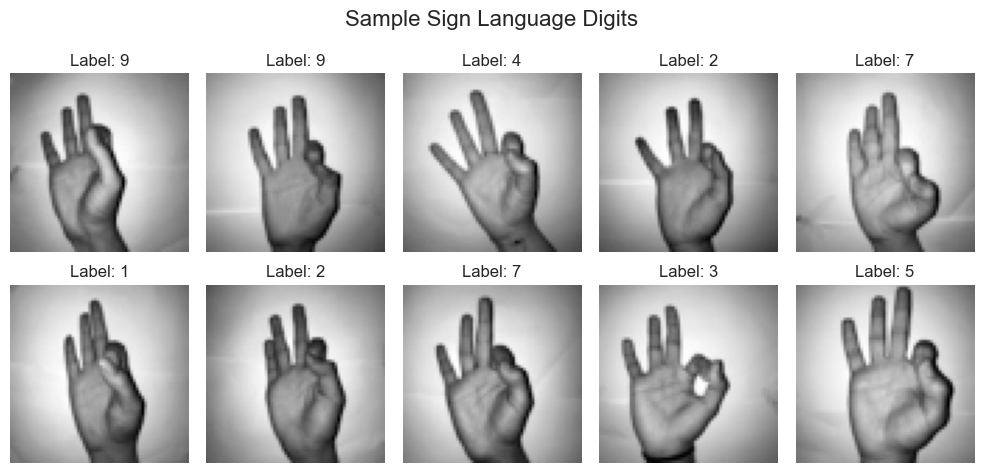

In [8]:
# Visualize sample images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train_cat[i])}")
    plt.axis('off')
plt.suptitle("Sample Sign Language Digits", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# Define CNN model
model = Sequential([
    Input((64, 64, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [10]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [12]:
# Checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [13]:
# Train the model
history = model.fit(X_train, y_train_cat,
                    epochs=250,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)

# Overfit for debugging
# history = model.fit(X_train[:100], y_train_cat[:100], epochs=20, verbose=1)

Epoch 1/250
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0931 - loss: 2.3031
Epoch 1: val_accuracy improved from -inf to 0.06970, saving model to model/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0931 - loss: 2.3031 - val_accuracy: 0.0697 - val_loss: 2.3028
Epoch 2/250
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1038 - loss: 2.3024
Epoch 2: val_accuracy improved from 0.06970 to 0.10909, saving model to model/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1064 - loss: 2.3024 - val_accuracy: 0.1091 - val_loss: 2.3020
Epoch 3/250
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1479 - loss: 2.3009
Epoch 3: val_accuracy did not improve from 0.10909
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1448 - loss: 2.3010 - val_accuracy: 0.0697 - val_loss: 2.3025
Epoch 4/250
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1045 - loss: 2.3016
Epoch 4: val_accuracy did not improve from 0.10909
21/21 ━━━━━━━━━━━━━

In [14]:
# Save the model
model.save("model/final_model.keras")
print("Model saved to 'model/final_model.h5'")

Model saved to 'model/final_model.h5'


In [15]:
# Load the final model
# loaded_model = load_model("model/final_model.h5")
# print("Model loaded from 'model/final_model.h5'")

# Load the best model
# best_model = load_model("model/best_model.h5")

In [16]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 80.87%
Test Loss: 0.6418


In [17]:
# Predict and analyze
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [18]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79        41
           1       0.90      0.88      0.89        41
           2       0.70      0.68      0.69        41
           3       0.81      0.73      0.77        41
           4       0.84      1.00      0.91        41
           5       0.85      0.79      0.81        42
           6       0.76      0.76      0.76        42
           7       0.92      0.80      0.86        41
           8       0.69      0.76      0.72        41
           9       0.88      0.88      0.88        42

    accuracy                           0.81       413
   macro avg       0.81      0.81      0.81       413
weighted avg       0.81      0.81      0.81       413



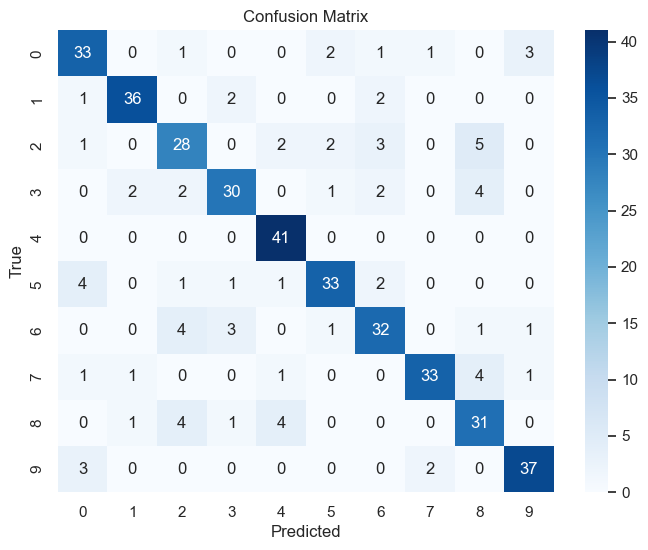

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [20]:
# Plot training history
plt.figure(figsize=(14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

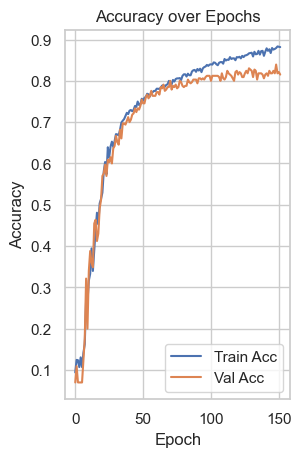

In [21]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

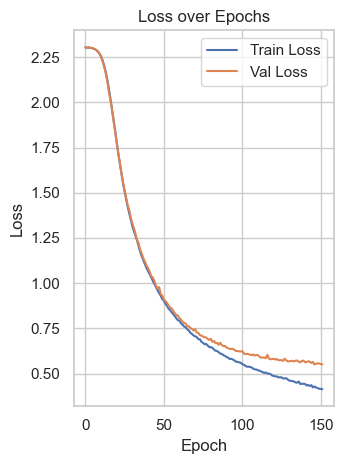

In [22]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()